# Outliars not Outliers

Author: Angie Waller

The following scripts were used to create charts in the book *Outliars: A Discourse Guide to Fact-Checking and Click-Baiting.*

The book can be found at https://www.unknownunknowns.org/product/outliars

In [33]:
import spacy
import textacy
nlp = spacy.load('en_core_web_sm')
import pandas as pd
from textblob import TextBlob
import datetime
import truecase

# Headlines collections
This dataset was created using The New York Times api to collect headlines of articled published in the last fifteen years. The csv file (allfinals.csv) filters this collection to headlines that included the president's last name. Only articles that were published during the president's term are considered for that president.

In [3]:
#import headline csv
#csv columns of interest are headline, date, president
df= pd.read_csv('allfinals.csv') 
headlines = [[x,y,z,a] for x, y,z,a in zip(df['date'], df['headline'],df['pres'], df['material_type'])]

In [5]:
df.head()

,Unnamed: 0,date,doc_type,headline,keywords,material_type,pres,section,web_url
0,4,2018-12-01,article,Trump Fund-Raiser Received Laundered Foreign M...,"['Presidential Election of 2016', 'United Stat...",News,trump,NaN,https://www.nytimes.com/2018/11/30/us/politics...
1,9,2018-12-01,article,Trump Administration Peppers Inboxes With Plug...,"['Health Insurance and Managed Care', 'Medicar...",News,trump,NaN,https://www.nytimes.com/2018/12/01/us/politics...
2,10,2018-12-01,article,Trump Tops Tricky Dick,['Russian Interference in 2016 US Elections an...,Op-Ed,trump,NaN,https://www.nytimes.com/2018/11/30/opinion/don...
3,12,2018-12-02,article,‘S.N.L.’ Has Alec Baldwin and Ben Stiller Play...,['Television'],News,trump,NaN,https://www.nytimes.com/2018/12/02/arts/televi...
4,13,2018-12-04,article,"Trump Warns China That He’s ‘Tariff Man,’ Spoo...","['United States Economy', 'Government Bonds', ...",News,trump,NaN,https://www.nytimes.com/2018/12/04/business/yi...


The following script creates two new data tables from the headlines. One considers the features of the headline such as word count and count of different parts of speech (POS). The other table analyzes the tokens and bigrams of the headlines, allowing consideration of trends in vocabulary and punctuation used to compose the headlines.

In [4]:
#building two new datatables
#one is for the headline stats including headline length, pos counts, date and pres
tokenlist=[]
headlinelist=[]

for headline in headlines:
    headline_d={}
    #headlines are converted to sentence case using true_case so that the POS tagger is more accurate
    headline_text=truecase.get_true_case(headline[1])
    date=headline[0]
    pres=headline[2]
    section=headline[3]
    
    
    #using the spacy.io tagger to label the headline
    doc=nlp(headline_text)
    
    #counting number of different POS for linguistic analysis
    words=[w for w in list(doc)]
    headline_d['length']=len([w for w in list(doc) if w.is_alpha])
    headline_d['nounct'] = len([w for w in words if w.pos_ == "NOUN"])
    headline_d['verbct'] = len([w for w in words if w.pos_ == "VERB"])
    headline_d['adjct'] = len([w for w in words if w.pos_ == "ADJ"])
    headline_d['advct'] = len([w for w in words if w.pos_ == "ADV"])  
    headline_d['date']=date
    headline_d['pres']=pres
    headline_d['section']=section

    #getting readability stats using textacy library
    #https://textacy.readthedocs.io/
    #these were not used in final analysis 
    #more work needs to be done to factor the number of syllables for presidents name not being a factor
    #i.e. Obama is a three syllable word that will skew readability levels compared to headlines with one syllable names like Trump and Bush
    
    ts = textacy.TextStats(doc)
    headline_d['syllables']=ts.n_syllables
    headline_d['chars']=ts.n_chars
    #headline_d['entropy']=ts.entropy
    headline_d['grade_level']=ts.flesch_kincaid_grade_level
    headline_d['flesch']=ts.flesch_reading_ease
    headline_d['lix']=ts.lix

    #getting sentiment analysis scores
    #these were not used in final anlysis, but kept for future study 
    headline_blob=TextBlob(headline_text)
    headline_d['polarity']=headline_blob.sentiment.polarity
    headline_d['subjectivity']=headline_blob.sentiment.subjectivity


    #in this table, headlines are broken down to token level to better analyze trends in word usage and punctuation
    headline_d['headline']=headline_text
    i=0
    for i in range(len(words)+1):
        word_d={}
        word_d['token']=words[i-1].text.lower()
        word_d['lemma']=words[i-1].lemma_
        word_d['pos']=words[i-1].pos_
        if i-2>=0:
            word_d['prev_word']=words[i-2].text.lower()
        if i!=0 and i!=len(words):
            word_d['bigram']=words[i-1].text.lower() + " " + words[i].text.lower()
        word_d['pres']=pres
        word_d['date']=date
    
        tokenlist.append(word_d)
        i+=1

    headlinelist.append(headline_d)

In [5]:
token_df=pd.DataFrame(tokenlist) 
doc_df=pd.DataFrame(headlinelist)

# Final headline table
The headline table contains headlines along with length(word count) and other features that can be used to analyze trends in headline composition over time.

In [6]:
doc_df.head()

,adjct,advct,chars,date,flesch,grade_level,headline,length,lix,nounct,polarity,pres,section,subjectivity,syllables,verbct
0,2,0,58,2018-12-01,37.900000,10.208889,Trump fund-raiser received laundered foreign m...,9,53.444444,4,-0.125,trump,News,0.125,17,3
1,2,0,65,2018-12-01,35.945000,10.730000,Trump administration Peppers Inboxes with plug...,10,60.000000,4,0.000,trump,News,0.375,19,0
2,2,0,19,2018-12-01,118.175000,-2.230000,Trump tops tricky Dick,4,4.000000,1,0.000,trump,Op-Ed,0.000,4,0
3,0,0,57,2018-12-02,95.939286,3.355714,‘ S. N. L. ’ has Alec Baldwin and Ben Stiller ...,11,35.428571,0,0.000,trump,News,0.000,16,1
4,0,0,53,2018-12-04,80.306364,4.790909,"Trump WARNS China that he ’ s ‘ tariff man, ’ ...",11,29.181818,5,0.000,trump,News,0.000,15,4


In [14]:
#make new column for year
def getyear(date):
    #first four numbers in date column are year
    return int(date[0:4])

doc_df['year']=doc_df['date'].apply(getyear)

This table groups headlines by year. The resulting counts are headlines that featured the serving president during the years in question.

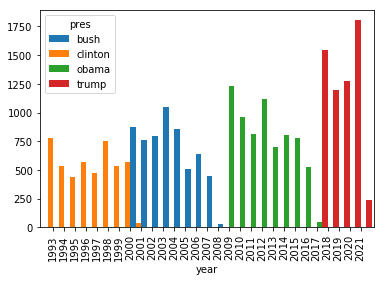

In [10]:
#calculating the count of headlines for each sitting president
%matplotlib inline
count_headlines = doc_df.pivot_table(values="headline", index="year", columns="pres", aggfunc=pd.Series.nunique)
count_headlines.plot(kind='bar',width=2.0)


This chart filters for only opinion and editoral pieces (provided in the NYT dataset). The result is headlines in these sections that featured the serving president's last name.

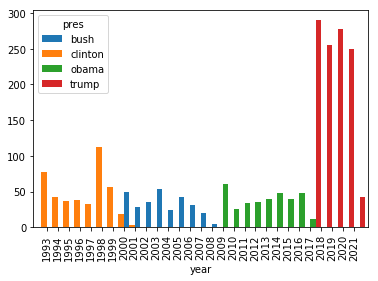

In [22]:
%matplotlib inline
opinion_list=['Op-Ed', 'Editorial', 'Opinion', 'Editorial; Letter','Letter']
count_opinion=doc_df[doc_df['section'].isin(opinion_list)].pivot_table(values="headline", index="year", columns="pres", aggfunc=pd.Series.nunique)
count_opinion.plot(kind='bar',width=2.0)

# Final token table

In [7]:
token_df.head()

,bigram,date,lemma,pos,pres,prev_word,token
0,NaN,2018-12-01,say,VERB,trump,NaN,say
1,trump fund,2018-12-01,trump,ADJ,trump,NaN,trump
2,fund -,2018-12-01,fund,NOUN,trump,trump,fund
3,- raiser,2018-12-01,-,PUNCT,trump,fund,-
4,raiser received,2018-12-01,raiser,NOUN,trump,-,raiser


In [15]:
token_df['year']=token_df['date'].apply(getyear)

In [24]:
token_df.head()

,bigram,date,lemma,pos,pres,prev_word,token,year
0,NaN,2018-12-01,say,VERB,trump,NaN,say,2018
1,trump fund,2018-12-01,trump,ADJ,trump,NaN,trump,2018
2,fund -,2018-12-01,fund,NOUN,trump,trump,fund,2018
3,- raiser,2018-12-01,-,PUNCT,trump,fund,-,2018
4,raiser received,2018-12-01,raiser,NOUN,trump,-,raiser,2018


The chart below aggregates usage of "?" punctuation in headlines by date. The results show a dramatic increase in using ?'s to frame headlines during the Trump administration.

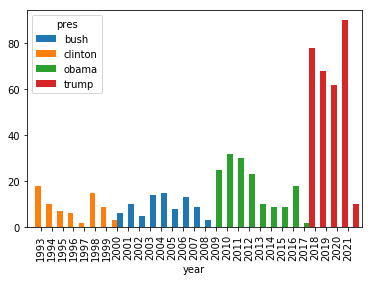

In [32]:
%matplotlib inline

count_questions=token_df[token_df['token']=="?"].pivot_table(values='date', index="year", columns="pres", aggfunc=pd.Series.nunique)
count_questions.plot(kind='bar',width=2.0)